In [6]:
import warnings, os, time
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.metrics import make_scorer, balanced_accuracy_score, roc_auc_score

from xgboost import XGBClassifier
import openml

from scipy.stats import uniform, loguniform, randint
from skopt import space
from skopt import BayesSearchCV

import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
import seaborn as sns 

from collections import defaultdict
import json

In [7]:
# --- Ustawienia globalne ---
RANDOM_STATE = 42
DATASET_IDS = [1590, 1471, 44, 1461] # [1494, 1480, 1049, 1464]
N_SPLITS = 10                # zmniejszony koszt walidacji
N_ITER = 100                 # liczba iteracji dla obu metod
N_JOBS = -1
SCORER = "roc_auc"
RESULTS_DIR = "results_xgb_fast"
os.makedirs(RESULTS_DIR, exist_ok=True)
CACHE_DIR = "cache_dir"
os.makedirs(CACHE_DIR, exist_ok=True)

In [8]:
# --- Funkcje pomocnicze ---
def load_openml_dataset(task_id, random_state=RANDOM_STATE):
    dataset = openml.datasets.get_dataset(task_id)
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute
    )
    cat_cols = [n for n, is_cat in zip(attribute_names, categorical_indicator) if is_cat and n in X.columns]
    num_cols = [c for c in X.columns if c not in cat_cols]

    # etykiety do 0..K-1
    y_s = pd.Series(y)
    if not pd.api.types.is_numeric_dtype(y_s):
        y = y_s.astype("category").cat.codes.to_numpy()
    else:
        _, y = np.unique(y_s.to_numpy(), return_inverse=True)
    return X, y, cat_cols, num_cols, dataset.name

def build_preprocess(cat_cols, num_cols):
    numeric = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=False))
    ])
    categorical = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
    ])
    return ColumnTransformer([
        ("num", numeric, num_cols),
        ("cat", categorical, cat_cols)
    ], remainder="drop", sparse_threshold=0.3)


def build_pipeline(cat_cols, num_cols):
    pre = build_preprocess(cat_cols, num_cols)
    clf = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=RANDOM_STATE,
        tree_method="hist",
        n_estimators=100,            # liczba drzew (boosting rounds)
        learning_rate=0.3,           # eta
        max_depth=6,                 # głębokość drzewa
        min_child_weight=1.0,        # min sum hessian in leaf
        subsample=1.0,               # próbkowanie obserwacji
        colsample_bytree=1.0,        # próbkowanie cech na poziomie drzewa
        colsample_bylevel=1.0,       # próbkowanie cech na poziomie poziomu drzewa
        booster="gbtree",            # typ boostera (gbtree / dart / gblinear)
        reg_lambda=1.0,              # L2 regularization term (lambda)
        reg_alpha=0.0,               # L1 regularization term (alpha)
        n_jobs=N_JOBS
    )
    pipe = Pipeline([
        ("pre", pre),
        ("clf", clf)
    ], memory=CACHE_DIR)
    return pipe

In [9]:
# --- Przestrzeń parametrów: tylko 5 kluczowych ---

RS_PARAM_DISTS = {
    # z artykułu: nrounds ∈ [1, 5000]
    #"clf__n_estimators": randint(1, 5001),

    # eta ∈ 2^[−10, 0]  -> (≈ 0.0009766, 1.0]
    "clf__learning_rate": loguniform(2**-10, 1.0),

    # subsample ∈ [0.1, 1.0]
    "clf__subsample": uniform(0.1, 0.9),

    # booster ∈ {gbtree, dart, gblinear}
    "clf__booster": ["gbtree"],

    # max_depth ∈ {1,…,15}
    "clf__max_depth": randint(1, 16),

    # min_child_weight ∈ 2^[0,7] -> [1, 128]
    "clf__min_child_weight": loguniform(1, 2**7),

    # colsample_bytree ∈ [0,1]
    "clf__colsample_bytree": uniform(0.3, 0.7),

    # colsample_bylevel ∈ [0,1]
    "clf__colsample_bylevel": uniform(0.3, 0.7),

    # lambda ∈ 2^[−10,10] -> [2^-10, 2^10]
    "clf__reg_lambda": loguniform(2**-10, 2**10),

    # alpha ∈ 2^[−10,10]
    "clf__reg_alpha": loguniform(2**-10, 2**10),
}

BAYES_SPACE = {
    #"clf__n_estimators": space.Integer(1, 5000),
    "clf__learning_rate": space.Real(2**-10, 1.0, prior="log-uniform"),
    "clf__subsample": space.Real(0.1, 1.0),
    "clf__booster": space.Categorical(["gbtree"]),
    "clf__max_depth": space.Integer(1, 15),
    "clf__min_child_weight": space.Real(1.0, 2**7, prior="log-uniform"),
    "clf__colsample_bytree": space.Real(0.3, 1.0),
    "clf__colsample_bylevel": space.Real(0.3, 1.0),
    "clf__reg_lambda": space.Real(2**-10, 2**10, prior="log-uniform"),
    "clf__reg_alpha": space.Real(2**-10, 2**10, prior="log-uniform"),
}

In [10]:
# --- Random Search ---
def run_random_search(pipe, X, y, dataset_name, n_iter=N_ITER):
    cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    rs = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=RS_PARAM_DISTS,
        n_iter=n_iter,
        scoring=SCORER,
        cv=cv,
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE,
        refit=True,
        return_train_score=False,
        verbose=1
    )
    rs.fit(X, y)
    df = pd.DataFrame(rs.cv_results_)
    df["method"] = "random_search"
    df["dataset"] = dataset_name
    df["iter"] = np.arange(1, len(df) + 1)
    return rs, df

In [11]:
# --- Bayes Search ---
def run_bayes_search(pipe, X, y, dataset_name, n_iter=N_ITER):
    cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

    optimizer_kwargs = {
        "base_estimator": "ET",             # Extra Trees jako surrogate
        "acq_func": "LCB",                  # eksploracyjna funkcja akwizycji
        "acq_func_kwargs": {"kappa": 5.0},  # ↑ eksploracja (spróbuj 2.0, 3.5, 5.0)
        "acq_optimizer": "sampling",        # szerokie szukanie maksimum akwizycji
        "n_initial_points": 32,             # lepsze pokrycie przestrzeni na starcie
        "initial_point_generator": "lhs", # równomierne próbkowanie
    }

    bs = BayesSearchCV(
        estimator=pipe,
        search_spaces=BAYES_SPACE,
        n_iter=n_iter,
        scoring=SCORER,
        cv=cv,
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE,
        refit=True,
        return_train_score=False,
        optimizer_kwargs=optimizer_kwargs,
        n_points=1,                         # sekwencyjnie – bez „zgrupowanych” punktów
        verbose=1
    )
    bs.fit(X, y)
    df = pd.DataFrame(bs.cv_results_)
    df["method"] = "bayes_search"
    df["dataset"] = dataset_name
    df["iter"] = np.arange(1, len(df) + 1)
    return bs, df

def get_default_score(pipe, X, y):
    cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    s = cross_val_score(pipe, X, y, scoring=SCORER, cv=cv, n_jobs=N_JOBS)
    return float(np.mean(s))

In [12]:
# --- Dwustopniowy eksperyment XGBoost (Globalny default + tuning per dataset) ---
all_histories, summaries = [], []

# ===============================================================
# 1️⃣ ETAP: USTALENIE GLOBALNEGO ZESTAWU PARAMETRÓW DEFAULTOWYCH
# ===============================================================
print("=== Etap 1: Ustalanie globalnych parametrów domyślnych (Random Search na wszystkich zbiorach) ===")
global_rs_results = []

for ds_id in tqdm(DATASET_IDS, desc="Default-tuning datasets"):
    X, y, cat_cols, num_cols, ds_name = load_openml_dataset(ds_id)
    pipe = build_pipeline(cat_cols, num_cols)

    # Random Search na danym zbiorze
    rs_model, rs_hist = run_random_search(pipe, X, y, ds_name, n_iter=N_ITER)
    rs_hist["dataset_id"] = ds_id
    rs_hist["dataset_name"] = ds_name
    global_rs_results.append(rs_hist)

# Połączenie wyników ze wszystkich zbiorów
global_rs_df = pd.concat(global_rs_results, ignore_index=True)

# Grupowe AUC dla każdej kombinacji hiperparametrów (średnia po datasetach)
param_cols = [c for c in global_rs_df.columns if c.startswith("param_clf__")]
mean_auc_by_paramset = (
    global_rs_df.groupby(param_cols)["mean_test_score"]
    .mean()
    .reset_index()
    .sort_values("mean_test_score", ascending=False)
)

# Najlepszy zestaw parametrów globalnych
best_default_params = mean_auc_by_paramset.iloc[0].to_dict()
best_default_auc = best_default_params.pop("mean_test_score")

# ✅ Usuń prefiks 'param_' (dodany przez sklearn) i upewnij się, że zostaje tylko 'clf__'
best_default_params = {
    k.replace("param_", ""): v
    for k, v in best_default_params.items()
}

# ✅ Jeśli jeszcze nie mają 'clf__', dodaj go
best_default_params = {
    (k if k.startswith("clf__") else f"clf__{k}"): v
    for k, v in best_default_params.items()
}

print("\n=== Wybrane globalne parametry defaultowe (na podstawie średniego AUC) ===")
for k, v in best_default_params.items():
    print(f"{k}: {v}")

print(f"Średni globalny ROC AUC (default): {best_default_auc:.4f}")

# Zapis globalnego zestawu parametrów
global_defaults_path = os.path.join(RESULTS_DIR, "global_default_params.json")
import json
with open(global_defaults_path, "w") as f:
    json.dump(best_default_params, f, indent=2)
print(f"Zapisano globalne parametry defaultowe: {global_defaults_path}")

=== Etap 1: Ustalanie globalnych parametrów domyślnych (Random Search na wszystkich zbiorach) ===


Default-tuning datasets:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits

=== Wybrane globalne parametry defaultowe (na podstawie średniego AUC) ===
clf__booster: gbtree
clf__colsample_bylevel: 0.3837159721568112
clf__colsample_bytree: 0.7992713510560965
clf__learning_rate: 0.19049836045462507
clf__max_depth: 10
clf__min_child_weight: 3.1424601249709023
clf__reg_alpha: 0.03399264550145132
clf__reg_lambda: 0.0017105450204680424
clf__subsample: 0.7395966007172087
Średni globalny ROC AUC (default): 0.9576
Zapisano globalne parametry defaultowe: results_xgb_fast\global_default_params.json


In [13]:
# ===============================================================
# 2️⃣ ETAP: TUNING PER DATASET WZGLĘDEM GLOBALNEGO DEFAULTU
# ===============================================================
print("\n=== Etap 2: Tuning per dataset względem globalnych parametrów defaultowych ===")

for ds_id in tqdm(DATASET_IDS, desc="Per-dataset tuning"):
    X, y, cat_cols, num_cols, ds_name = load_openml_dataset(ds_id)
    print(f"\n### Dataset {ds_id} — {ds_name} | X: {X.shape}, classes: {len(np.unique(y))}")

    pipe = build_pipeline(cat_cols, num_cols)

    # --- Ustaw parametry globalne jako defaultowe ---
    pipe.set_params(**best_default_params)

    # --- Wynik bazowy (z globalnymi defaultami) ---
    t0 = time.time()
    default_auc_global = get_default_score(pipe, X, y)
    t1 = time.time()
    print(f"Global default ROC AUC: {default_auc_global:.4f} ({t1 - t0:.1f}s)")

    # --- Random Search (dla porównania) ---
    rs_model, rs_hist = run_random_search(pipe, X, y, ds_name, n_iter=N_ITER)
    rs_file = os.path.join(RESULTS_DIR, f"history_random_{ds_id}.csv")
    rs_hist.to_csv(rs_file, index=False)
    print(f"Saved: {rs_file}")

    # --- Bayes Search ---
    bs_model, bs_hist = run_bayes_search(pipe, X, y, ds_name, n_iter=N_ITER)
    bs_file = os.path.join(RESULTS_DIR, f"history_bayes_{ds_id}.csv")
    bs_hist.to_csv(bs_file, index=False)
    print(f"Saved: {bs_file}")

    # --- Najlepsze wyniki ---
    rs_best = rs_hist.loc[rs_hist["rank_test_score"].idxmin()]
    bs_best = bs_hist.loc[bs_hist["rank_test_score"].idxmin()]

    # --- Dodanie najlepszych parametrów do podsumowania ---
    rs_best_params = {k.replace('param_', ''): rs_best[k] for k in rs_best.index if k.startswith('param_')}
    bs_best_params = {k.replace('param_', ''): bs_best[k] for k in bs_best.index if k.startswith('param_')}

    summaries.append({
        "dataset_id": ds_id,
        "dataset_name": ds_name,
        "default_auc_global": default_auc_global,
        "rs_best_auc": float(rs_best["mean_test_score"]),
        "bs_best_auc": float(bs_best["mean_test_score"]),
        "rs_auc_gain": float(rs_best["mean_test_score"]) - default_auc_global,
        "bs_auc_gain": float(bs_best["mean_test_score"]) - default_auc_global,
        "default_time_sec": t1 - t0,
        "rs_best_params": json.dumps(rs_best_params, ensure_ascii=False),
        "bs_best_params": json.dumps(bs_best_params, ensure_ascii=False)
    })

    # --- Częściowy zapis ---
    pd.DataFrame(summaries).to_csv(
        os.path.join(RESULTS_DIR, "summary_partial.csv"), index=False
    )

    all_histories.extend([rs_hist, bs_hist])
    pd.concat(all_histories, ignore_index=True).to_csv(
        os.path.join(RESULTS_DIR, "history_all_partial.csv"), index=False
    )

# --- Końcowy zapis ---
hist_all = pd.concat(all_histories, ignore_index=True)
hist_all.to_csv(os.path.join(RESULTS_DIR, "history_all.csv"), index=False)

summary_df = pd.DataFrame(summaries)
summary_df.to_csv(os.path.join(RESULTS_DIR, "summary.csv"), index=False)

print("\n✅ DONE. Final summary (ROC AUC vs global default):")
display(summary_df)



=== Etap 2: Tuning per dataset względem globalnych parametrów defaultowych ===


Per-dataset tuning:   0%|          | 0/4 [00:00<?, ?it/s]


### Dataset 1590 — adult | X: (48842, 14), classes: 2
Global default ROC AUC: 0.9263 (4.4s)
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Saved: results_xgb_fast\history_random_1590.csv
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
F

,dataset_id,dataset_name,default_auc_global,rs_best_auc,bs_best_auc,rs_auc_gain,bs_auc_gain,default_time_sec,rs_best_params,bs_best_params
0,1590,adult,0.926335,0.928966,0.929633,0.002631,0.003298,4.402680,"{""clf__booster"": ""gbtree"", ""clf__colsample_byl...","{""clf__booster"": ""gbtree"", ""clf__colsample_byl..."
1,1471,eeg-eye-state,0.985887,0.987178,0.980347,0.001291,-0.005540,0.730306,"{""clf__booster"": ""gbtree"", ""clf__colsample_byl...","{""clf__booster"": ""gbtree"", ""clf__colsample_byl..."
2,44,spambase,0.986297,0.988084,0.989000,0.001787,0.002703,0.649271,"{""clf__booster"": ""gbtree"", ""clf__colsample_byl...","{""clf__booster"": ""gbtree"", ""clf__colsample_byl..."
3,1461,bank-marketing,0.931836,0.935831,0.935779,0.003995,0.003943,1.759642,"{""clf__booster"": ""gbtree"", ""clf__colsample_byl...","{""clf__booster"": ""gbtree"", ""clf__colsample_byl..."


### Analiza

1. Ile iteracji każdej metody potrzebujemy żeby uzyskać stabilne wyniki optymalizacji?

In [29]:
# --- katalogi ---
RESULTS_DIR_PRIMARY = "results_xgb_fast"
RESULTS_DIR_FALLBACK = "results_xgb_tunability"

# ✅ pełna lista wszystkich strojoncych parametrów z wcześniejszego kodu
TUNED_PARAM_COLS = [
    "param_clf__learning_rate",      # loguniform(2**-10, 1.0)
    "param_clf__subsample",          # uniform(0.1, 0.9)
    "param_clf__booster",            # Categorical(["gbtree"])
    "param_clf__max_depth",          # randint(1, 16)
    "param_clf__min_child_weight",   # loguniform(1, 2**7)
    "param_clf__colsample_bytree",   # uniform(0.3, 0.7)
    "param_clf__colsample_bylevel",  # uniform(0.3, 0.7)
    "param_clf__reg_lambda",         # loguniform(2**-10, 2**10)
    "param_clf__reg_alpha",          # loguniform(2**-10, 2**10)
]

# --- pomocnicza funkcja do wczytywania wyników ---
def _read_results(dir_):
    hist_p = os.path.join(dir_, "history_all.csv")
    summ_p = os.path.join(dir_, "summary.csv")
    if not (os.path.exists(hist_p) and os.path.exists(summ_p)):
        return None, None

    # czytanie z kompatybilnością (nowy pandas)
    hist = pd.read_csv(
        hist_p,
        keep_default_na=True,
        na_values=["None", "none", "NaN", "nan", "NULL", "null", ""],
        engine="python"  # wyłącza low_memory warnings
    )
    summ = pd.read_csv(summ_p, engine="python")
    return hist, summ

# --- spróbuj wczytać dane z katalogu głównego lub zapasowego ---
RESULTS_DIR = None
hist_all = summary_df = None
for d in [RESULTS_DIR_PRIMARY, RESULTS_DIR_FALLBACK]:
    h, s = _read_results(d)
    if h is not None:
        RESULTS_DIR = d
        hist_all, summary_df = h, s
        print(f"✓ Wczytuję wyniki z: {d}")
        break

if hist_all is None:
    raise FileNotFoundError("Nie znaleziono history_all.csv / summary.csv w znanych katalogach.")

# --- konwersja kolumn param_* do typu numerycznego ---
def coerce_param_columns_numeric(df, param_cols):
    df = df.copy()
    for c in param_cols:
        if c not in df.columns:
            continue
        s = df[c].astype(str).str.strip().str.replace(",", ".", regex=False)
        s = s.str.replace(r"[^0-9eE\.\+\-]", "", regex=True)
        s = s.replace({"": np.nan, "nan": np.nan, "NaN": np.nan, "None": np.nan})
        df[c] = pd.to_numeric(s, errors="coerce")
    return df

hist_all = coerce_param_columns_numeric(hist_all, TUNED_PARAM_COLS)

# --- dopilnuj, żeby miara (mean_test_score) i iteracja były liczbami ---
if "mean_test_score" in hist_all.columns:
    hist_all["mean_test_score"] = pd.to_numeric(hist_all["mean_test_score"], errors="coerce")
if "iter" in hist_all.columns:
    hist_all["iter"] = pd.to_numeric(hist_all["iter"], errors="coerce")

# --- sanity check: podgląd struktur danych ---
print("\nDtypes (wycinek):")
subset_cols = [c for c in TUNED_PARAM_COLS if c in hist_all.columns] + ["mean_test_score", "iter"]
print(hist_all[subset_cols].dtypes)

print("\nsummary_df.head():")
print(summary_df.head(2).to_string(index=False))

print("\nhist_all.head():")
print(hist_all.head(2).to_string(index=False))


✓ Wczytuję wyniki z: results_xgb_fast

Dtypes (wycinek):
param_clf__learning_rate        float64
param_clf__subsample            float64
param_clf__booster              float64
param_clf__max_depth              int64
param_clf__min_child_weight     float64
param_clf__colsample_bytree     float64
param_clf__colsample_bylevel    float64
param_clf__reg_lambda           float64
param_clf__reg_alpha            float64
mean_test_score                 float64
iter                              int64
dtype: object

summary_df.head():
 dataset_id  dataset_name  default_auc_global  rs_best_auc  bs_best_auc  rs_auc_gain  bs_auc_gain  default_time_sec                                                                                                                                                                                                                                                                                                                                             rs_best_params       

,dataset,method,iters_to_stable,best_auc
0,adult,bayes_search,5,0.929633
1,adult,random_search,1,0.928966
2,bank-marketing,bayes_search,5,0.935779
3,bank-marketing,random_search,1,0.935831
4,eeg-eye-state,bayes_search,5,0.980347
5,eeg-eye-state,random_search,8,0.987178
6,spambase,bayes_search,5,0.989000
7,spambase,random_search,8,0.988084


Zapisano: results_xgb_fast\stability_by_dataset.csv


,method,n,mean,median,min,max,% stabilnych ≤ 100 iter
0,bayes_search,4,5.0,5.0,5,5,100.0
1,random_search,4,4.5,4.5,1,8,100.0


Zapisano: results_xgb_fast\stability_summary.csv


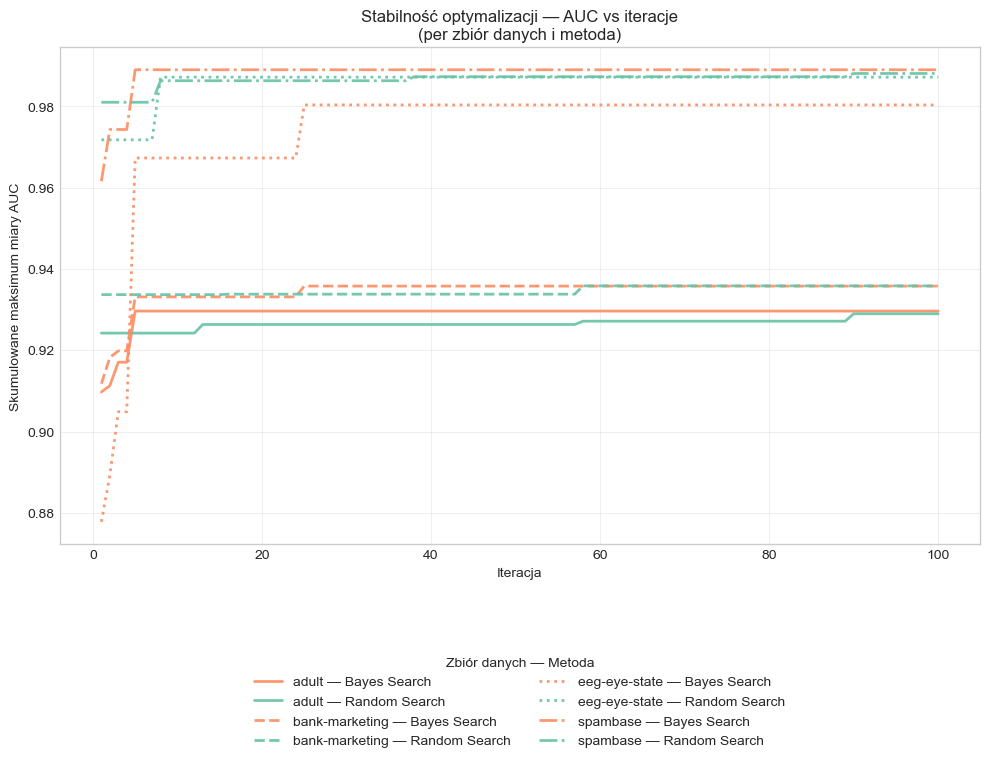

Zapisano wykres: results_xgb_fast\running_best_by_dataset_auc.png


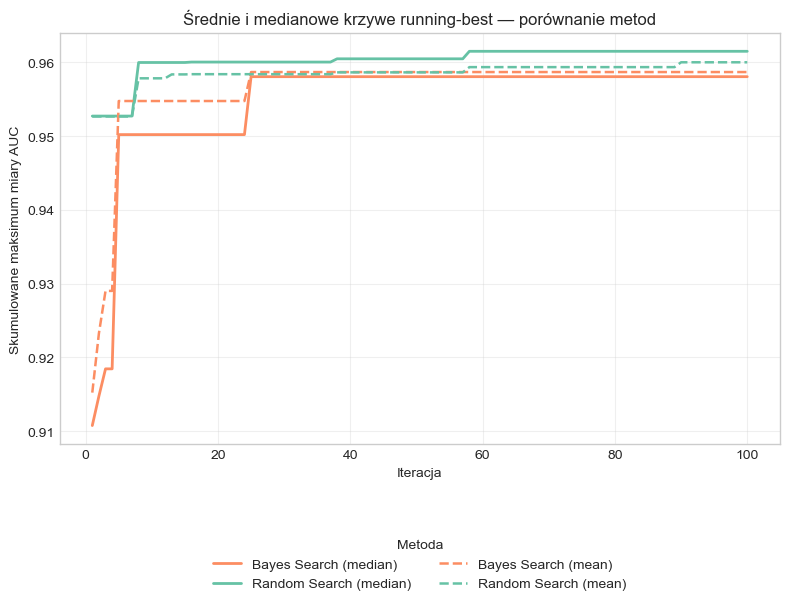

Zapisano wykres: results_xgb_fast\running_best_methods_agg_auc.png

=== Ile iteracji potrzeba do stabilności (patience=10, tol=1e-3) ===
  bayes_search: median=5, mean=5.0, min=5, max=5, stabilnych ≤ 100: 100.0%
 random_search: median=4, mean=4.5, min=1, max=8, stabilnych ≤ 100: 100.0%


In [30]:
# --- pomocnicze: prawdziwa kolejność ewaluacji w obrębie (dataset, method) ---
def add_eval_iteration(df):
    df = df.copy()
    # jeśli kolumna 'iter' istnieje z poprzedniego skryptu, zachowaj jej kolejność
    if "iter" in df.columns:
        df = df.sort_values(["dataset", "method", "iter"])
        df["iter_eval"] = df.groupby(["dataset", "method"]).cumcount() + 1
    else:
        df["iter_eval"] = df.groupby(["dataset", "method"]).cumcount() + 1
    return df


# --- definicja stabilności: brak poprawy running-best przez 'patience' iteracji o więcej niż 'tol' ---
def iterations_to_stability(df_group, patience=10, tol=1e-3):
    g = df_group.sort_values("iter_eval")
    scores = g["mean_test_score"].to_numpy()
    running_best = np.maximum.accumulate(scores)
    # szukamy najmniejszego i, po którym przez 'patience' kolejnych prób nie ma poprawy > tol
    for i in range(len(running_best) - patience):
        window_max_after = running_best[i + 1:i + 1 + patience].max()
        if (window_max_after - running_best[i]) < tol:
            return int(i + 1)
    return int(len(running_best))


# --- przygotowanie danych z iteracjami ---
hist_ord = add_eval_iteration(hist_all)

# --- oblicz stabilność per (dataset, method) ---
stab_rows = []
for (dname, method), g in hist_ord.groupby(["dataset", "method"]):
    iters = iterations_to_stability(g, patience=10, tol=1e-3)
    stab_rows.append({
        "dataset": dname,
        "method": method,
        "iters_to_stable": iters,
        "best_auc": g["mean_test_score"].max()
    })

stability_df = pd.DataFrame(stab_rows).sort_values(["dataset", "method"]).reset_index(drop=True)
display(stability_df)

# --- zapis do CSV ---
stab_csv = os.path.join(RESULTS_DIR, "stability_by_dataset.csv")
stability_df.to_csv(stab_csv, index=False)
print(f"Zapisano: {stab_csv}")

# --- podsumowania liczbowe per metoda ---
summary_stab = (
    stability_df
    .groupby("method")["iters_to_stable"]
    .agg(["count", "mean", "median", "min", "max"])
    .rename(columns={"count": "n"})
    .reset_index()
)

# liczba iteracji zdefiniowana w eksperymencie
N_ITER = int(hist_ord.groupby(["dataset", "method"]).size().groupby(level=1).max().max()) if "N_ITER" not in globals() else N_ITER

# odsetek, który ustabilizował się w <= N_ITER
pct_le_N = (
    stability_df
    .assign(le_cap=lambda d: d["iters_to_stable"] <= N_ITER)
    .groupby("method")["le_cap"].mean()
    .mul(100)
    .round(1)
    .rename(f"% stabilnych ≤ {N_ITER} iter")
)
summary_stab = summary_stab.merge(pct_le_N, on="method", how="left")
display(summary_stab)

summary_csv = os.path.join(RESULTS_DIR, "stability_summary.csv")
summary_stab.to_csv(summary_csv, index=False)
print(f"Zapisano: {summary_csv}")

# --- Kolory metod — spójne z wcześniejszymi wykresami ---
method_colors = {
    "random_search": "#66c2a5",  # zielony
    "bayes_search": "#fc8d62"    # pomarańczowo-różowy
}

# Style linii dla zbiorów danych (dla czytelności)
line_styles = ["-", "--", ":", "-."]

# Mapowanie datasetów na style (rotacja co 4)
datasets_sorted = sorted(hist_ord["dataset"].unique())
dataset_styles = {
    ds: line_styles[i % len(line_styles)] for i, ds in enumerate(datasets_sorted)
}

# --- 1️⃣ Wykres: running-best AUC po rzeczywistej kolejności ewaluacji ---
plt.figure(figsize=(10, 6))
for (dname, method), g in hist_ord.groupby(["dataset", "method"]):
    g = g.sort_values("iter_eval")
    rb = g["mean_test_score"].cummax()
    plt.plot(
        g["iter_eval"], rb,
        label=f"{dname} — {method.replace('_', ' ').title()}",
        color=method_colors.get(method, "gray"),
        linestyle=dataset_styles.get(dname, "-"),
        linewidth=2,
        alpha=0.9
    )

plt.xlabel("Iteracja")
plt.ylabel("Skumulowane maksimum miary AUC")
plt.title("Stabilność optymalizacji — AUC vs iteracje\n(per zbiór danych i metoda)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend(title="Zbiór danych — Metoda", loc="upper center", bbox_to_anchor=(0.5, -0.20),
           ncol=2, frameon=False)
plot1 = os.path.join(RESULTS_DIR, "running_best_by_dataset_auc.png")
plt.savefig(plot1, dpi=150, bbox_inches="tight")
plt.show()
print(f"Zapisano wykres: {plot1}")


# --- 2️⃣ Wykres: porównanie metod (średni / medianowy running-best) ---
def agg_running_best(df, how="median"):
    curves = []
    for (dname, method), g in df.groupby(["dataset", "method"]):
        g = g.sort_values("iter_eval")
        rb = g["mean_test_score"].cummax().reset_index(drop=True)
        rb.index = np.arange(1, len(rb) + 1)
        curves.append(pd.DataFrame({
            "iter_eval": rb.index,
            "rb": rb.values,
            "method": method,
            "dataset": dname
        }))
    curves = pd.concat(curves, ignore_index=True)
    agg = curves.groupby(["method", "iter_eval"])["rb"]
    agg = (agg.median() if how == "median" else agg.mean()).reset_index(name=f"rb_{how}")
    return agg


agg_med = agg_running_best(hist_ord, how="median")
agg_mean = agg_running_best(hist_ord, how="mean")

plt.figure(figsize=(8, 5))
for method, g in agg_med.groupby("method"):
    plt.plot(
        g["iter_eval"], g["rb_median"],
        label=f"{method.replace('_', ' ').title()} (median)",
        color=method_colors.get(method, "gray"),
        linewidth=2
    )
for method, g in agg_mean.groupby("method"):
    plt.plot(
        g["iter_eval"], g["rb_mean"],
        linestyle="--",
        label=f"{method.replace('_', ' ').title()} (mean)",
        color=method_colors.get(method, "gray"),
        linewidth=1.8
    )

plt.xlabel("Iteracja")
plt.ylabel("Skumulowane maksimum miary AUC")
plt.title("Średnie i medianowe krzywe running-best — porównanie metod")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend(title="Metoda", loc="upper center", bbox_to_anchor=(0.5, -0.20),
           ncol=2, frameon=False)
plot2 = os.path.join(RESULTS_DIR, "running_best_methods_agg_auc.png")
plt.savefig(plot2, dpi=150, bbox_inches="tight")
plt.show()
print(f"Zapisano wykres: {plot2}")

# --- 3️⃣ Zestawienie liczbowe stabilności ---
print("\n=== Ile iteracji potrzeba do stabilności (patience=10, tol=1e-3) ===")
for method, g in stability_df.groupby("method"):
    vals = g["iters_to_stable"].to_numpy()
    print(f"{method:>14}: median={np.median(vals):.0f}, mean={np.mean(vals):.1f}, "
          f"min={vals.min()}, max={vals.max()}, stabilnych ≤ {N_ITER}: {(vals <= N_ITER).mean() * 100:.1f}%")


2. Określenie zakresów hiperparametrów dla poszczególnych modeli - motywacja wynikająca z literatury.

In [31]:
# --- 2) Zakresy hiperparametrów na bazie TOP 20% (druk, bez I/O) ---

TOP_FRAC = 0.20  # top 20%

# ✅ pełna lista strojoncych parametrów (zgodna z RS_PARAM_DISTS i BAYES_SPACE)
TUNED_PARAM_COLS = [
    "param_clf__learning_rate",
    "param_clf__subsample",
    "param_clf__booster",
    "param_clf__max_depth",
    "param_clf__min_child_weight",
    "param_clf__colsample_bytree",
    "param_clf__colsample_bylevel",
    "param_clf__reg_lambda",
    "param_clf__reg_alpha",
]

# --- pomocnicze drukowanie ---
def _show_df(df, title=None, max_rows=200, max_cols=200, float_fmt="{:,.6g}"):
    if title:
        print("\n" + title)
        print("-" * len(title))
    if df is None or len(df) == 0:
        print("(pusto)")
        return
    with pd.option_context(
        "display.max_rows", max_rows,
        "display.max_columns", max_cols,
        "display.width", 200,
        "display.float_format", float_fmt.format
    ):
        print(df.to_string(index=False))

# --- sanity check kolumn (bez I/O) ---
need = {"dataset", "method", "mean_test_score", "iter"} | set(TUNED_PARAM_COLS)
missing = [c for c in need if c not in hist_all.columns]
if missing:
    raise ValueError(f"Brakuje kolumn w danych: {missing}")

# --- globalna, odporna konwersja param_* do liczb (bez numeric_only) ---
def _coerce_param_numeric(df, param_cols):
    df = df.copy()
    for c in param_cols:
        if c not in df.columns:
            continue
        s = df[c].astype(str).str.strip().str.replace(",", ".", regex=False)
        s = s.str.replace(r"[^0-9eE\.\+\-]", "", regex=True)
        s = s.replace({"": np.nan, "nan": np.nan, "NaN": np.nan, "None": np.nan}).infer_objects(copy=False)
        df[c] = pd.to_numeric(s, errors="coerce")
    return df

hist_num = _coerce_param_numeric(hist_all, TUNED_PARAM_COLS).copy()
hist_num["mean_test_score"] = pd.to_numeric(hist_num["mean_test_score"], errors="coerce")
hist_num["iter"] = pd.to_numeric(hist_num["iter"], errors="coerce")

# --- porządek ewaluacji ---
hist_ord = hist_num.sort_values(["dataset", "method", "iter"]).copy()
hist_ord["iter_eval"] = hist_ord.groupby(["dataset", "method"]).cumcount() + 1

# --- funkcja do obliczania kwantyli (robusta na małych próbkach) ---
def _robust_quantiles(series):
    s = pd.to_numeric(series, errors="coerce").dropna()
    if len(s) == 0:
        return np.nan, np.nan, np.nan
    if len(s) < 3:
        return float(s.min()), float(s.median()), float(s.max())
    q = np.quantile(s, [0.05, 0.5, 0.95])
    return float(q[0]), float(q[1]), float(q[2])

def top_configs_quantiles_robust(df, by=("dataset", "method"), top_frac=TOP_FRAC, min_top=5):
    rows = []
    for keys, g in df.groupby(list(by)):
        keydict = dict(zip(by, keys if isinstance(keys, tuple) else (keys,)))
        if len(g) == 0:
            continue
        top_k = max(min_top, int(np.ceil(len(g) * top_frac)))
        topg = g.nlargest(top_k, "mean_test_score")

        recs = []
        for pcol in TUNED_PARAM_COLS:
            if pcol not in topg.columns:
                continue
            q05, q50, q95 = _robust_quantiles(topg[pcol])
            recs.append({"param": pcol, "q05": q05, "q50": q50, "q95": q95})
        if not recs:
            continue
        qs = pd.DataFrame(recs)
        for k, v in keydict.items():
            qs[k] = v
        rows.append(qs)

    if not rows:
        return pd.DataFrame(columns=["param", "q05", "q50", "q95", *by])
    return pd.concat(rows, ignore_index=True)

# --- wyniki: per (dataset, method) i agregat per metoda ---
q_by_ds_method = (
    top_configs_quantiles_robust(hist_ord, by=("dataset", "method"), top_frac=TOP_FRAC, min_top=5)
    .sort_values(["dataset", "method", "param"])
    .reset_index(drop=True)
)
q_overall = (
    top_configs_quantiles_robust(hist_ord, by=("method",), top_frac=TOP_FRAC, min_top=5)
    .sort_values(["method", "param"])
    .reset_index(drop=True)
)

_show_df(q_by_ds_method, f"Kwantyle TOP-{int(TOP_FRAC * 100)}% per (dataset, method)")
_show_df(q_overall, f"Kwantyle TOP-{int(TOP_FRAC * 100)}% agregowane per metoda (łączone zbiory)")

# --- czytelne zakresy [q05, q95] per metoda (propozycja do kolejnego tuningu) ---
def _pretty_range(row):
    p = row["param"]
    q05, q95 = row["q05"], row["q95"]
    if pd.isna(q05) or pd.isna(q95):
        return "—"
    # max_depth to parametr dyskretny → zaokrąglamy
    if p == "param_clf__max_depth":
        return f"[{int(np.floor(q05))}, {int(np.ceil(q95))}]"
    return f"[{q05:.4g}, {q95:.4g}]"

print(f"\nProponowane zakresy dla kolejnego tuningu (na bazie TOP-{int(TOP_FRAC*100)}% konfiguracji):")
for method, g in q_overall.groupby("method"):
    gg = g.copy()
    gg["suggested_range"] = gg.apply(_pretty_range, axis=1)
    print(f"\n[{method}]")
    _show_df(gg[["param", "q05", "q50", "q95", "suggested_range"]], max_rows=100)



Kwantyle TOP-20% per (dataset, method)
--------------------------------------
                       param        q05       q50      q95        dataset        method
          param_clf__booster        NaN       NaN      NaN          adult  bayes_search
param_clf__colsample_bylevel   0.412555  0.592066 0.986455          adult  bayes_search
 param_clf__colsample_bytree   0.330756  0.652693 0.954205          adult  bayes_search
    param_clf__learning_rate  0.0145121  0.113769 0.942307          adult  bayes_search
        param_clf__max_depth        2.9       9.5    14.05          adult  bayes_search
 param_clf__min_child_weight    1.06205   1.92271  62.5464          adult  bayes_search
        param_clf__reg_alpha 0.00122146  0.169136  28.1337          adult  bayes_search
       param_clf__reg_lambda 0.00172815 0.0967671  161.571          adult  bayes_search
        param_clf__subsample   0.230749  0.677602 0.882538          adult  bayes_search
          param_clf__booster        NaN  

C:\Users\helen\AppData\Local\Temp\ipykernel_11712\1385279595.py:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  s = s.replace({"": np.nan, "nan": np.nan, "NaN": np.nan, "None": np.nan}).infer_objects(copy=False)


3. Tunowalność poszczególnych algorytmów.

✓ Analiza per zbiór danych z katalogu: results_xgb_fast

=== adult ===
Iteracje: RS=100, BS=100
Mediana tunowalności RS=-0.0148, BS=-0.0204
Test Wilcoxona: stat=2138.000, p=0.1833
→ Brak istotnej różnicy (p ≥ 0.05)


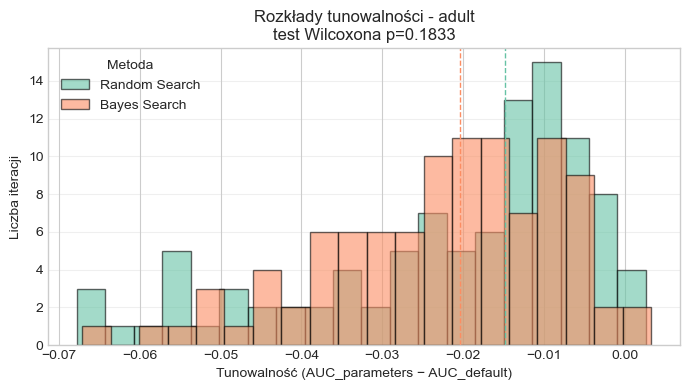

Zapisano histogram: results_xgb_fast\hist_tunability_adult.png

=== bank-marketing ===
Iteracje: RS=100, BS=100
Mediana tunowalności RS=-0.0205, BS=-0.1017
Test Wilcoxona: stat=666.000, p=0.0000
→ Istotna różnica (p < 0.05)


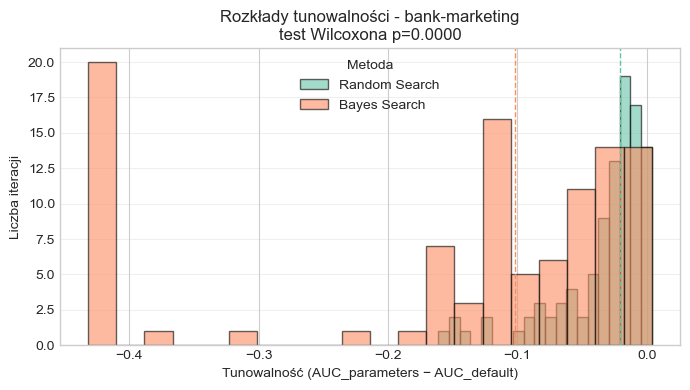

Zapisano histogram: results_xgb_fast\hist_tunability_bank-marketing.png

=== eeg-eye-state ===
Iteracje: RS=100, BS=100
Mediana tunowalności RS=-0.1318, BS=-0.1985
Test Wilcoxona: stat=1941.000, p=0.0446
→ Istotna różnica (p < 0.05)


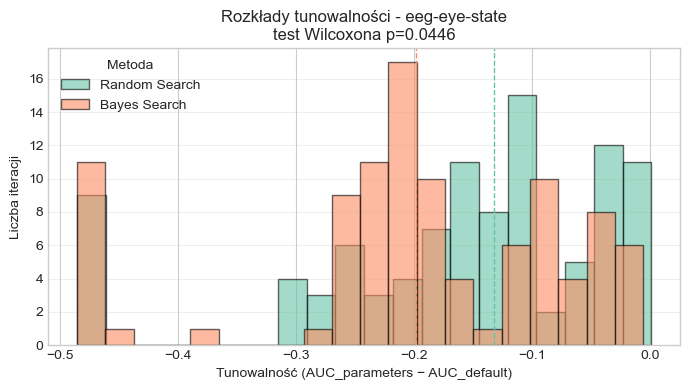

Zapisano histogram: results_xgb_fast\hist_tunability_eeg-eye-state.png

=== spambase ===
Iteracje: RS=100, BS=100
Mediana tunowalności RS=-0.0219, BS=-0.0574
Test Wilcoxona: stat=1136.000, p=0.0000
→ Istotna różnica (p < 0.05)


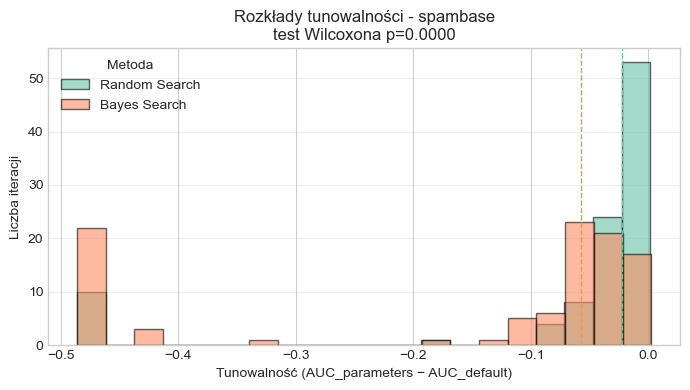

Zapisano histogram: results_xgb_fast\hist_tunability_spambase.png

 Zapisano wyniki testu Wilcoxona per zbiór danych do: results_xgb_fast\wilcoxon_tunability_per_dataset.csv


In [32]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

# --- katalog z wynikami ---
RESULTS_DIR_PRIMARY = "results_xgb_fast"
RESULTS_DIR_FALLBACK = "results_xgb_tunability"

RESULTS_DIR = None
for d in [RESULTS_DIR_PRIMARY, RESULTS_DIR_FALLBACK]:
    if os.path.exists(os.path.join(d, "summary.csv")):
        RESULTS_DIR = d
        break
if RESULTS_DIR is None:
    raise FileNotFoundError("Nie znaleziono wyników w katalogach results_xgb_fast ani results_xgb_tunability.")

print(f"✓ Analiza per zbiór danych z katalogu: {RESULTS_DIR}")

# --- pomocnicze: wczytanie wszystkich plików historycznych ---
def load_all_histories(results_dir):
    dfs = []
    for f in os.listdir(results_dir):
        if f.startswith("history_random_") or f.startswith("history_bayes_"):
            df = pd.read_csv(os.path.join(results_dir, f), engine="python")
            if "random" in f:
                df["method"] = "random_search"
            elif "bayes" in f:
                df["method"] = "bayes_search"
            else:
                continue
            # wyodrębnij dataset_id z nazwy pliku
            ds_id = os.path.splitext(f)[0].split("_")[-1]
            df["dataset_id"] = ds_id
            dfs.append(df)
    if not dfs:
        raise FileNotFoundError("Nie znaleziono plików history_*.csv w katalogu wyników.")
    return pd.concat(dfs, ignore_index=True)

# --- wczytanie historii i konwersje ---
hist_all = load_all_histories(RESULTS_DIR)
hist_all["mean_test_score"] = pd.to_numeric(hist_all["mean_test_score"], errors="coerce")
hist_all["dataset_id"] = hist_all["dataset_id"].astype(str)

# --- wczytaj summary ---
summary_path = os.path.join(RESULTS_DIR, "summary.csv")
summary_df = pd.read_csv(summary_path)
summary_df["dataset_id"] = summary_df["dataset_id"].astype(str)

# zgodność ze starą i nową wersją (default_auc lub default_auc_global)
if "default_auc_global" in summary_df.columns:
    summary_df["default_auc"] = pd.to_numeric(summary_df["default_auc_global"], errors="coerce")
elif "default_auc" in summary_df.columns:
    summary_df["default_auc"] = pd.to_numeric(summary_df["default_auc"], errors="coerce")
else:
    raise ValueError("Brak kolumny 'default_auc' lub 'default_auc_global' w summary.csv")

# --- połączenie historii z summary ---
hist_merged = hist_all.merge(
    summary_df[["dataset_id", "dataset_name", "default_auc"]],
    on="dataset_id",
    how="left"
)

# --- oblicz tunowalność per iteracja ---
hist_merged["tunability"] = hist_merged["mean_test_score"] - hist_merged["default_auc"]

# --- sanity check ---
if hist_merged["tunability"].isna().all():
    raise ValueError("Wszystkie wartości tunowalności są puste — sprawdź nazwy kolumn lub dane wejściowe.")

# --- kolory metod ---
method_colors = {
    "random_search": "#66c2a5",  # zielony
    "bayes_search": "#fc8d62"    # pomarańczowo-różowy
}

# --- analiza i testy Wilcoxona per zbiór ---
results = []

for ds_name, g in hist_merged.groupby("dataset_name"):
    rs = g.loc[g["method"] == "random_search", "tunability"].dropna()
    bs = g.loc[g["method"] == "bayes_search", "tunability"].dropna()

    if len(rs) == 0 or len(bs) == 0:
        print(f"\n⚠️ Pomijam {ds_name} — brak kompletu danych RS/BS.")
        continue

    # Dopasowanie długości serii, jeśli różna liczba iteracji
    n = min(len(rs), len(bs))
    rs, bs = rs.iloc[:n], bs.iloc[:n]

    # Test Wilcoxona
    try:
        stat, p = wilcoxon(rs, bs)
    except ValueError:
        stat, p = np.nan, np.nan

    results.append({
        "dataset_name": ds_name,
        "n_rs": len(rs),
        "n_bs": len(bs),
        "median_rs": np.median(rs),
        "median_bs": np.median(bs),
        "wilcoxon_stat": stat,
        "wilcoxon_p": p
    })

    print(f"\n=== {ds_name} ===")
    print(f"Iteracje: RS={len(rs)}, BS={len(bs)}")
    print(f"Mediana tunowalności RS={np.median(rs):.4f}, BS={np.median(bs):.4f}")
    print(f"Test Wilcoxona: stat={stat:.3f}, p={p:.4f}")
    if not np.isnan(p):
        if p < 0.05:
            print("→ Istotna różnica (p < 0.05)")
        else:
            print("→ Brak istotnej różnicy (p ≥ 0.05)")

    # --- histogram tunowalności ---
    plt.figure(figsize=(7, 4))
    plt.hist(rs, bins=20, alpha=0.6, label="Random Search",
             color=method_colors["random_search"], edgecolor="black")
    plt.hist(bs, bins=20, alpha=0.6, label="Bayes Search",
             color=method_colors["bayes_search"], edgecolor="black")
    plt.axvline(np.median(rs), color=method_colors["random_search"], linestyle="--", linewidth=1)
    plt.axvline(np.median(bs), color=method_colors["bayes_search"], linestyle="--", linewidth=1)
    plt.title(f"Rozkłady tunowalności - {ds_name}\ntest Wilcoxona p={p:.4f}")
    plt.xlabel("Tunowalność (AUC_parameters − AUC_default)")
    plt.ylabel("Liczba iteracji")
    plt.legend(title="Metoda")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()

    out_path = os.path.join(RESULTS_DIR, f"hist_tunability_{ds_name.replace(' ', '_')}.png")
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    plt.show()
    print(f"Zapisano histogram: {out_path}")

# --- zapis wyników testu ---
if results:
    wilcox_df = pd.DataFrame(results)
    wilcox_path = os.path.join(RESULTS_DIR, "wilcoxon_tunability_per_dataset.csv")
    wilcox_df.to_csv(wilcox_path, index=False)
    print(f"\n Zapisano wyniki testu Wilcoxona per zbiór danych do: {wilcox_path}")
else:
    print("\n Brak kompletnych danych do zapisania wyników Wilcoxona.")


3. Tunowalność poszczególnych hiperparametrów.

In [18]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scipy.stats import uniform, loguniform, randint
from tqdm.auto import tqdm
from skopt import BayesSearchCV
from skopt import space
from sklearn.exceptions import FitFailedWarning
import warnings

# --- wycisz błędy dopasowań ---
warnings.filterwarnings("ignore", category=FitFailedWarning)

# --- Wczytaj globalne parametry defaultowe ---
with open(os.path.join(RESULTS_DIR, "global_default_params.json"), "r") as f:
    best_default_params = json.load(f)

print("✓ Wczytano globalne parametry defaultowe:")
for k, v in best_default_params.items():
    print(f"{k}: {v}")

# --- Przestrzenie przeszukiwania dla pojedynczych parametrów ---
SINGLE_PARAM_SPACES_RS = {
    "clf__learning_rate": loguniform(2**-10, 1.0),
    "clf__subsample": uniform(0.1, 0.9),
    "clf__max_depth": randint(1, 16),
    "clf__min_child_weight": loguniform(1, 2**7),
    "clf__colsample_bytree": uniform(0.3, 0.7),
    "clf__colsample_bylevel": uniform(0.3, 0.7),
    "clf__reg_lambda": loguniform(2**-10, 2**10),
    "clf__reg_alpha": loguniform(2**-10, 2**10),
}

SINGLE_PARAM_SPACES_BAYES = {
    "clf__learning_rate": space.Real(2**-10, 1.0, prior="log-uniform"),
    "clf__subsample": space.Real(0.1, 1.0),
    "clf__max_depth": space.Integer(1, 16),  # 👈 INT!
    "clf__min_child_weight": space.Real(1.0, 2**7, prior="log-uniform"),
    "clf__colsample_bytree": space.Real(0.3, 1.0),
    "clf__colsample_bylevel": space.Real(0.3, 1.0),
    "clf__reg_lambda": space.Real(2**-10, 2**10, prior="log-uniform"),
    "clf__reg_alpha": space.Real(2**-10, 2**10, prior="log-uniform"),
}

# --- lista parametrów analizowanych ---
PARAM_ORDER = [
    "clf__learning_rate",
    "clf__max_depth",
    "clf__subsample",
    "clf__colsample_bytree",
    "clf__reg_lambda",
]

# --- zbiorcze wyniki ---
sensitivity_records = []

✓ Wczytano globalne parametry defaultowe:
clf__booster: gbtree
clf__colsample_bylevel: 0.3837159721568112
clf__colsample_bytree: 0.7992713510560965
clf__learning_rate: 0.19049836045462507
clf__max_depth: 10
clf__min_child_weight: 3.1424601249709023
clf__reg_alpha: 0.03399264550145132
clf__reg_lambda: 0.0017105450204680424
clf__subsample: 0.7395966007172087


In [19]:
# ===========================================================
# TUNING POJEDYNCZEGO PARAMETRU — DWIE METODY
# ===========================================================
for ds_id in tqdm(DATASET_IDS, desc="Datasets (dual-method sensitivity)"):
    X, y, cat_cols, num_cols, ds_name = load_openml_dataset(ds_id)
    print(f"\n### Dataset {ds_id} — {ds_name} | X: {X.shape}, classes: {len(np.unique(y))}")

    pipe = build_pipeline(cat_cols, num_cols)
    pipe.set_params(**best_default_params)

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
    default_auc = get_default_score(pipe, X, y)
    print(f"Default ROC AUC: {default_auc:.4f}")

    for param_name in PARAM_ORDER:
        print(f" → Strojenie {param_name} (pozostałe = default)")

        # --- RANDOM SEARCH ---
        param_dist = {param_name: SINGLE_PARAM_SPACES_RS[param_name]}
        rs = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=param_dist,
            n_iter=N_ITER,
            scoring="roc_auc",
            cv=cv,
            n_jobs=-1,
            random_state=RANDOM_STATE,
            refit=False,
            return_train_score=False,
            error_score=np.nan,
            verbose=0
        )
        rs.fit(X, y)
        df_rs = pd.DataFrame(rs.cv_results_)
        df_rs["method"] = "random_search"

        # --- BAYESIAN OPTIMIZATION ---
        bayes = BayesSearchCV(
            estimator=pipe,
            search_spaces={param_name: SINGLE_PARAM_SPACES_BAYES[param_name]},
            n_iter=N_ITER,
            scoring="roc_auc",
            cv=cv,
            n_jobs=-1,
            random_state=RANDOM_STATE,
            refit=False,
            return_train_score=False,
            verbose=0,
            optimizer_kwargs={
                "base_estimator": "ET",             
                "acq_func": "LCB",                  
                "acq_func_kwargs": {"kappa": 5.0},  
                "acq_optimizer": "sampling",        
                "n_initial_points": 32,             
                "initial_point_generator": "lhs", 
            }
        )
        bayes.fit(X, y)
        df_bs = pd.DataFrame(bayes.cv_results_)
        df_bs["method"] = "bayes_search"

        # --- scal wyniki ---
        df = pd.concat([df_rs, df_bs], ignore_index=True)
        df["dataset_name"] = ds_name
        df["param_name"] = param_name
        df["default_auc"] = default_auc
        df["tunability"] = df["mean_test_score"] - default_auc
        sensitivity_records.append(df)

Datasets (dual-method sensitivity):   0%|          | 0/4 [00:00<?, ?it/s]


### Dataset 1590 — adult | X: (48842, 14), classes: 2
Default ROC AUC: 0.9263
 → Strojenie clf__learning_rate (pozostałe = default)
 → Strojenie clf__max_depth (pozostałe = default)


C:\Users\helen\AppData\Roaming\Python\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1] before, using random point [2]
  warnings.warn(
C:\Users\helen\AppData\Roaming\Python\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1] before, using random point [14]
  warnings.warn(
C:\Users\helen\AppData\Roaming\Python\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1] before, using random point [6]
  warnings.warn(
C:\Users\helen\AppData\Roaming\Python\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1] before, using random point [6]
  warnings.warn(
C:\Users\helen\AppData\Roaming\Python\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1] before, using random point [4]
 

 → Strojenie clf__subsample (pozostałe = default)
 → Strojenie clf__colsample_bytree (pozostałe = default)
 → Strojenie clf__reg_lambda (pozostałe = default)

### Dataset 1471 — eeg-eye-state | X: (14980, 14), classes: 2
Default ROC AUC: 0.9859
 → Strojenie clf__learning_rate (pozostałe = default)
 → Strojenie clf__max_depth (pozostałe = default)


C:\Users\helen\AppData\Roaming\Python\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1] before, using random point [2]
  warnings.warn(
C:\Users\helen\AppData\Roaming\Python\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1] before, using random point [14]
  warnings.warn(
C:\Users\helen\AppData\Roaming\Python\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1] before, using random point [6]
  warnings.warn(
C:\Users\helen\AppData\Roaming\Python\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1] before, using random point [6]
  warnings.warn(
C:\Users\helen\AppData\Roaming\Python\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1] before, using random point [4]
 

 → Strojenie clf__subsample (pozostałe = default)
 → Strojenie clf__colsample_bytree (pozostałe = default)
 → Strojenie clf__reg_lambda (pozostałe = default)

### Dataset 44 — spambase | X: (4601, 57), classes: 2
Default ROC AUC: 0.9863
 → Strojenie clf__learning_rate (pozostałe = default)
 → Strojenie clf__max_depth (pozostałe = default)


C:\Users\helen\AppData\Roaming\Python\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1] before, using random point [2]
  warnings.warn(
C:\Users\helen\AppData\Roaming\Python\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1] before, using random point [14]
  warnings.warn(
C:\Users\helen\AppData\Roaming\Python\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1] before, using random point [6]
  warnings.warn(
C:\Users\helen\AppData\Roaming\Python\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1] before, using random point [6]
  warnings.warn(
C:\Users\helen\AppData\Roaming\Python\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1] before, using random point [4]
 

 → Strojenie clf__subsample (pozostałe = default)
 → Strojenie clf__colsample_bytree (pozostałe = default)
 → Strojenie clf__reg_lambda (pozostałe = default)

### Dataset 1461 — bank-marketing | X: (45211, 16), classes: 2
Default ROC AUC: 0.9318
 → Strojenie clf__learning_rate (pozostałe = default)


C:\Users\helen\AppData\Roaming\Python\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.08636935548628914] before, using random point [0.45558351444791034]
  warnings.warn(


 → Strojenie clf__max_depth (pozostałe = default)


C:\Users\helen\AppData\Roaming\Python\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1] before, using random point [2]
  warnings.warn(
C:\Users\helen\AppData\Roaming\Python\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1] before, using random point [14]
  warnings.warn(
C:\Users\helen\AppData\Roaming\Python\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1] before, using random point [6]
  warnings.warn(
C:\Users\helen\AppData\Roaming\Python\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1] before, using random point [6]
  warnings.warn(
C:\Users\helen\AppData\Roaming\Python\Python312\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1] before, using random point [4]
 

 → Strojenie clf__subsample (pozostałe = default)
 → Strojenie clf__colsample_bytree (pozostałe = default)
 → Strojenie clf__reg_lambda (pozostałe = default)


In [20]:
# ===========================================================
# PODSUMOWANIE I ZAPIS
# ===========================================================
sensitivity_df = pd.concat(sensitivity_records, ignore_index=True)
sensitivity_df = sensitivity_df[sensitivity_df["param_name"].isin(PARAM_ORDER)]
out_csv = os.path.join(RESULTS_DIR, "sensitivity_dualmethod.csv")
sensitivity_df.to_csv(out_csv, index=False)
print(f"\n✅ Zapisano wyniki tuningu dwóch metod do: {out_csv}")


✅ Zapisano wyniki tuningu dwóch metod do: results_xgb_fast\sensitivity_dualmethod.csv


In [33]:
# ===========================================================
# ANALIZA: Najwyższa tunowalność i odpowiadająca jej wartość parametru
# ===========================================================
import numpy as np
import pandas as pd
import os

# Zakładamy, że sensitivity_df już istnieje (np. wczytany z pliku CSV)
# sensitivity_df = pd.read_csv(out_csv)

# Usunięcie wierszy z brakującą tunowalnością (na wszelki wypadek)
sensitivity_df = sensitivity_df.dropna(subset=["tunability", "param_name"])

# Znajdź indeksy wierszy o najwyższej tunowalności dla każdego datasetu i parametru
idx = sensitivity_df.groupby(["dataset_name", "param_name"])["tunability"].idxmax()
best_tunability = sensitivity_df.loc[idx].copy().reset_index(drop=True)

# Wyciągnięcie wartości parametru odpowiadającej danej nazwie parametru
def extract_best_value(row):
    col_name = f"param_{row['param_name']}"
    if col_name in sensitivity_df.columns:
        return row[col_name]
    return np.nan

best_tunability["best_param_value"] = best_tunability.apply(extract_best_value, axis=1)

# Wybór i uporządkowanie kolumn
best_tunability = best_tunability[
    ["dataset_name", "method", "param_name", "best_param_value", "tunability", "mean_test_score", "default_auc"]
].sort_values(["dataset_name", "param_name"]).reset_index(drop=True)

# Zapis do pliku
out_best_csv = os.path.join(RESULTS_DIR, "sensitivity_best_per_param.csv")
best_tunability.to_csv(out_best_csv, index=False)

# Czytelny wydruk
print("\n✅ Najwyższa tunowalność per dataset i parametr:")
for ds, subdf in best_tunability.groupby("dataset_name"):
    print(f"\n📘 Dataset: {ds}")
    for _, row in subdf.iterrows():
        print(
            f"  • {row['param_name']}: tunability = {row['tunability']:.4f}, "
            f"best value = {row['best_param_value']}, method = {row['method']}"
        )

print(f"\n💾 Zapisano szczegóły do: {out_best_csv}")



✅ Najwyższa tunowalność per dataset i parametr:

📘 Dataset: adult
  • clf__colsample_bytree: tunability = 0.0025, best value = 0.3325152889039984, method = random_search
  • clf__learning_rate: tunability = 0.0024, best value = 0.11097713475488893, method = bayes_search
  • clf__max_depth: tunability = 0.0024, best value = 5.0, method = random_search
  • clf__reg_lambda: tunability = 0.0018, best value = 5.524954320445049, method = random_search
  • clf__subsample: tunability = 0.0014, best value = 0.9881982429404655, method = random_search

📘 Dataset: bank-marketing
  • clf__colsample_bytree: tunability = 0.0019, best value = 0.619248988951925, method = random_search
  • clf__learning_rate: tunability = 0.0054, best value = 0.05929875759930063, method = random_search
  • clf__max_depth: tunability = 0.0040, best value = 6.0, method = random_search
  • clf__reg_lambda: tunability = 0.0050, best value = 19.224787473851677, method = random_search
  • clf__subsample: tunability = 0.0029,

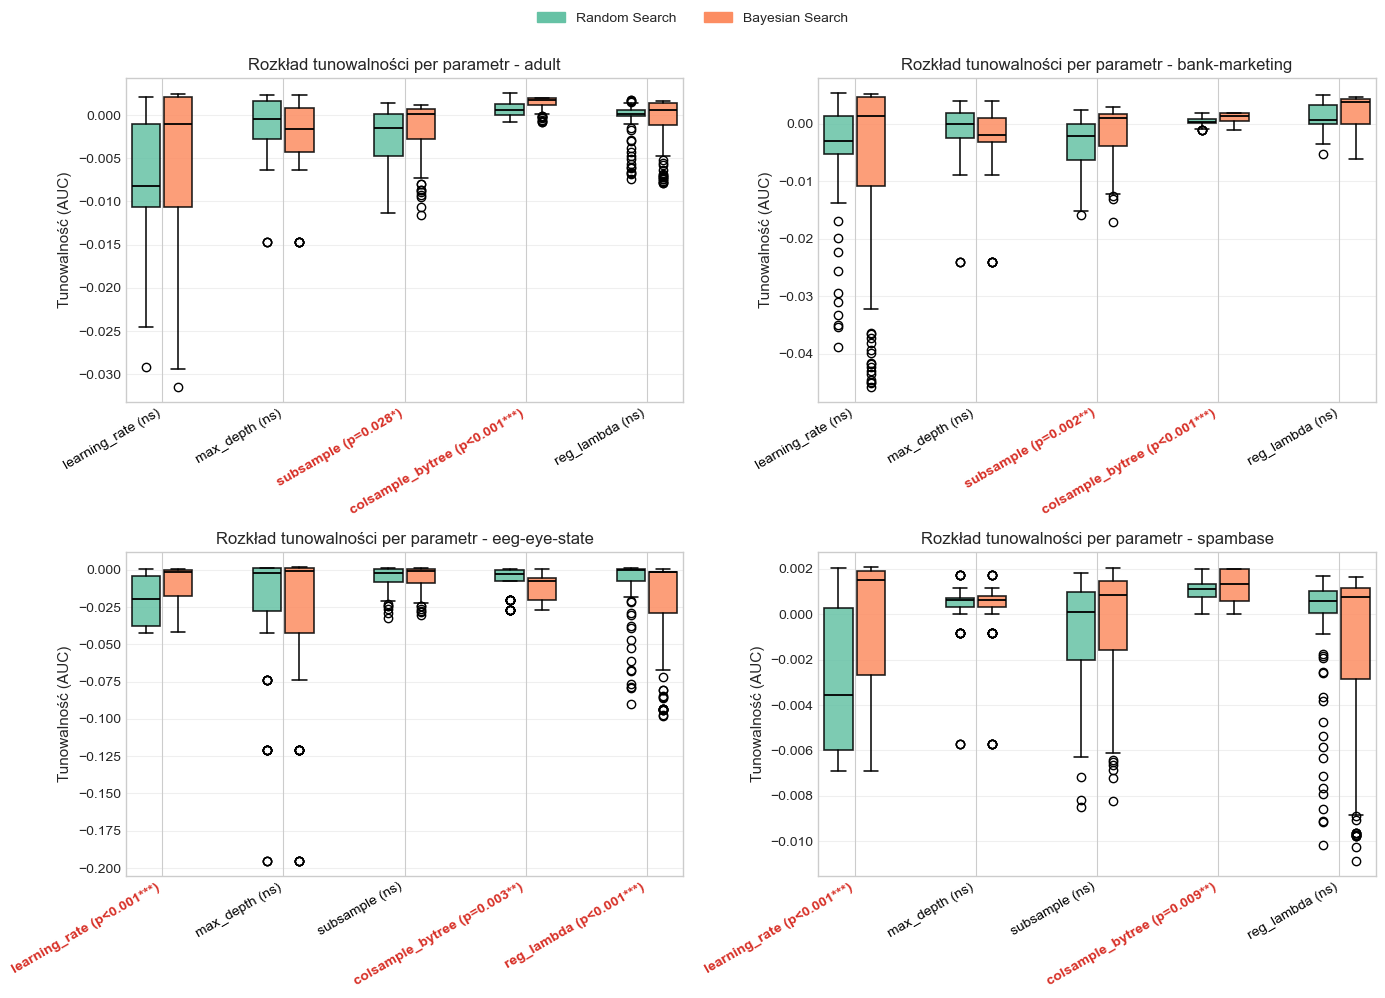


 Zapisano wykresy boxplot z pogrubionymi nazwami istotnych parametrów: results_xgb_fast\sensitivity_boxplots_dualmethod_wilcoxon_bold.png


In [34]:
# ===========================================================
# WYKRESY BOXPLOT — 2 METODY PER PARAMETR I ZBIÓR (Wilcoxon + pogrubienie)
# ===========================================================
import matplotlib.patches as mpatches
from scipy.stats import wilcoxon

plt.style.use("seaborn-v0_8-whitegrid")
method_colors = {"random_search": "#66c2a5", "bayes_search": "#fc8d62"}  # zielony i pomarańczowo-różowy
n_datasets = sensitivity_df["dataset_name"].nunique()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (ds_name, g) in enumerate(sensitivity_df.groupby("dataset_name")):
    ax = axes[i]
    g["param_name"] = pd.Categorical(g["param_name"], categories=PARAM_ORDER, ordered=True)

    positions = np.arange(1, len(PARAM_ORDER) * 3, 3)
    xtick_labels = []
    xtick_styles = []  # do przechowywania, które etykiety mają być pogrubione

    for j, param in enumerate(PARAM_ORDER):
        g_param = g[g["param_name"] == param]
        rs_vals = g_param[g_param["method"] == "random_search"]["tunability"].dropna()
        bs_vals = g_param[g_param["method"] == "bayes_search"]["tunability"].dropna()

        # --- Boxplot ---
        box = ax.boxplot(
            [rs_vals, bs_vals],
            positions=[positions[j]-0.4, positions[j]+0.4],
            widths=0.7,
            patch_artist=True,
            labels=["", ""],
            medianprops=dict(color="black", linewidth=1.3),
            boxprops=dict(linewidth=1.2),
            whiskerprops=dict(linewidth=1.1),
            capprops=dict(linewidth=1.1)
        )

        for patch, color in zip(box["boxes"], [method_colors["random_search"], method_colors["bayes_search"]]):
            patch.set_facecolor(color)
            patch.set_alpha(0.85)
            patch.set_edgecolor("black")

        # --- Test Wilcoxona ---
        p = np.nan
        if len(rs_vals) > 0 and len(bs_vals) > 0:
            n = min(len(rs_vals), len(bs_vals))
            try:
                stat, p = wilcoxon(rs_vals.iloc[:n], bs_vals.iloc[:n])
            except ValueError:
                pass

        # --- Etykieta z p-value ---
        if np.isnan(p):
            label = f"{param.replace('clf__', '')} (n/a)"
            is_bold = False
        elif p < 0.001:
            label = f"{param.replace('clf__', '')} (p<0.001***)"
            is_bold = True
        elif p < 0.01:
            label = f"{param.replace('clf__', '')} (p={p:.3f}**)"
            is_bold = True
        elif p < 0.05:
            label = f"{param.replace('clf__', '')} (p={p:.3f}*)"
            is_bold = True
        else:
            label = f"{param.replace('clf__', '')} (ns)"
            is_bold = False

        xtick_labels.append(label)
        xtick_styles.append(is_bold)

    # --- Ustawienia osi ---
    ax.set_title(f"Rozkład tunowalności per parametr - {ds_name}", fontsize=12)
    ax.set_ylabel("Tunowalność (AUC)", fontsize=11)
    ax.set_xticks(positions)
    ax.set_xticklabels(xtick_labels, rotation=30, ha="right", fontsize=10)
    ax.grid(axis="y", alpha=0.3)

    # Pogrub wybrane etykiety
    for tick_label, bold in zip(ax.get_xticklabels(), xtick_styles):
        if bold:
            tick_label.set_fontweight("bold")
            tick_label.set_color("#d73027")  # czerwony akcent
        else:
            tick_label.set_fontweight("normal")
            tick_label.set_color("black")

# ✅ Legenda z kolorami
handles = [
    mpatches.Patch(color=method_colors["random_search"], label="Random Search"),
    mpatches.Patch(color=method_colors["bayes_search"], label="Bayesian Search"),
]
fig.legend(handles=handles, loc="upper center", ncol=2, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plot_path = os.path.join(RESULTS_DIR, "sensitivity_boxplots_dualmethod_wilcoxon_bold.png")
plt.savefig(plot_path, dpi=150, bbox_inches="tight")
plt.show()

print(f"\n Zapisano wykresy boxplot z pogrubionymi nazwami istotnych parametrów: {plot_path}")


4. Czy technika losowania punktów wpływa na różnice we wnioskach w punkcie 3 dotyczących tunowalności algorytmów i hiperparametrów - Odpowiedź na pytanie czy występuje bias sampling.